<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">Model Results Visualization</h4>
    <p style="font-size: 20px;">NBA API Seasons 2021-22 to 2023-24</p>
</div>

<a name="models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)

**[1. Model Test Scores](#1.-Model-Test-Scores)**

- [1.1. Combined](#1.1.-Combined)

- [1.2. Separate](#1.2.-Separate)

# Setup

[Return to top](#models)

In [1]:
import sys
from pathlib import Path
# get current working directory
cwd = %pwd
# add shared_code directory to Python sys.path
sys.path.append(str(Path(cwd).parent / "shared_code"))
# import all libraries in shared_code directory 'imports.py' file
from imports import *
%matplotlib inline

/Users/sworthin/micromamba/envs/tflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

[Return to top](#models)

In [2]:
model_results_df = pd.read_csv('../../data/model_results/model_results.csv')

In [3]:
# rename outcome columns
rename_outcomes = {
    'GAME RESULT ACC': 'Game Winner',
    'TOTAL PTS': 'Score Total',
    'PLUS MINUS': 'Score Difference'
}

model_results_df.rename(columns=rename_outcomes, inplace=True)

In [4]:
# Consolidate 'Selected' feature sets into 'Selected Subset'
model_results_df['Feature Set'] = model_results_df['Feature Set'].replace({'Selected Filter-Wrapper': 'Selected Subset', 
                                                                           'Selected Embedded': 'Selected Subset'})

# Exclude 'AdvStats & TrackBoxStats' feature sets
model_results_df = model_results_df[~model_results_df['Feature Set'].isin(['AdvStats & TrackBoxStats'])]

In [5]:
model_results_df.head()

,Model,Tuned,Training Set,Test Set,Feature Set,n game rolling,Score Total,Score Difference,Game Winner,GAME RESULT AUROC,GAME RESULT F1
0,Null,No,Static,One season,NaN,NaN,20.28,15.32,0.56,0.50,0.00
1,GLM,No,Expanding,One game,Boxscores,5.0,18.92,14.49,0.64,0.67,0.70
2,GLM,No,Expanding,One game,Boxscores,10.0,18.73,14.41,0.65,0.68,0.72
3,GLM,No,Expanding,One game,Opponent Impact,5.0,20.79,14.36,0.63,0.68,0.70
4,GLM,No,Expanding,One game,Opponent Impact,10.0,20.74,14.23,0.63,0.68,0.70


In [6]:
# Filter the DataFrame for 'n game rolling' == 5 and not 'NULL' model
df_models = model_results_df[model_results_df['Model'] != 'Null']

# Get the 'NULL' model baseline values for comparison
null_model = model_results_df[model_results_df['Model'] == 'Null']

<a name="1.-Model-Test-Scores"></a>
# 1. Model Test Scores

[Return to top](#models)

<a name="1.1.-Combined"></a>
## 1.1. Combined

[Return to top](#models)

In [9]:
def reorder_legend(handles, labels, special_items):
    # Move specified items to the end of the legend
    special_handles, special_labels = [], []
    for item in special_items:
        if item in labels:
            index = labels.index(item)
            special_handles.append(handles.pop(index))
            special_labels.append(labels.pop(index))
    # Append the special items back at the end
    handles.extend(special_handles)
    labels.extend(special_labels)
    return handles, labels


def plot_combined_outcome_deviation(df, null_data, outcomes):

    # Define your custom order for the models here
    custom_model_order = ['GLM', 'Elastic Net', 'KNN', 'SVM', 'RF', 'XGB', 
                          'ARIMAX', 'FFNN', 'LSTM', 'N-BEATS', 'patchTST', 'timeGPT']  

    # Ensure the DataFrame is sorted by this custom order
    model_order_categorical = pd.Categorical(df['Model'], categories=custom_model_order, ordered=True)
    df['Model'] = model_order_categorical
    sorted_df = df.sort_values(by='Model')
    
    # Define the figure for subplots
    fig, axes = plt.subplots(1, len(outcomes), figsize=(4 * len(outcomes), 6), sharey=True)

    # Prepare a variable for collecting legend handles across all plots
    #all_handles, all_labels = [], set()
    all_handles_dict = {}

    for ax, outcome in zip(axes, outcomes):
        baseline = null_data[outcome].values[0]

        plot = sns.pointplot(ax=ax, data=sorted_df, x=outcome, y='Model', hue='Feature Set',
                      join=False, palette='tab10', dodge=0.8,
                      markers='D', scale=0.75, orient="h")
        
        # Add a vertical line for the 'NULL' model baseline and a label for it
        ax.axvline(x=baseline, color='gray', linestyle='--', label=f'Null Model Baseline')

        # Conditional x-axis label text based on the outcome value
        if outcome == "Game Winner":
            baseline_text = 'Baseline\nAccuracy'
            offset = 0.004
            text_x_position = baseline + offset  
            horizontal_alignment = 'left'
        else:
            baseline_text = 'Baseline\nRMSE'
            offset = 0.08
            text_x_position = baseline - offset 
            horizontal_alignment = 'right'
        
        num_models = len(custom_model_order)
        ax.text(text_x_position, num_models - 1, f'{baseline_text}: {baseline:.2f}', 
            color='#333333', fontsize=12, verticalalignment='top', horizontalalignment=horizontal_alignment)
    
        # Add alternating grey and white bands in the background
        for i, model in enumerate(sorted(df['Model'].unique(), reverse=True)):
            if i % 2 == 0:
                ax.axhspan(i-0.5, i+0.5, color='grey', alpha=0.1, lw=0)

        # Set the title and x-axis label conditionally
        ax.set_title(f'{outcome}', fontsize=15)
        xlabel = 'Accuracy' if outcome == "Game Winner" else 'RMSE'
        ax.set_xlabel(xlabel, fontsize=15)
        ax.set_ylabel('Model', fontsize=15)
        
        # Set the font size of the tick labels
        ax.tick_params(axis='both', which='major', labelsize=13)

        # Remove existing legends from individual subplots
        ax.get_legend().remove()

        # Collect handles and labels for the legend
        handles, labels = ax.get_legend_handles_labels()
        for handle, label in zip(handles, labels):
            all_handles_dict[label] = handle  # Update or add the handle-label mapping

    # Order the handles based on the labels, maintaining the initial insertion order
    ordered_labels = list(all_handles_dict.keys())
    ordered_handles = [all_handles_dict[label] for label in ordered_labels]
    
    # Apply reorder logic for "Selected Subset" and "All 248"
    ordered_handles, ordered_labels = reorder_legend(ordered_handles, ordered_labels, ['Selected Subset', 'All 248'])

    # Create a single combined legend outside the rightmost subplot
    fig.legend(ordered_handles, ordered_labels, title='Feature Set', title_fontsize=15, 
               loc='center left', bbox_to_anchor=(0.84, 0.5), frameon=False, fontsize=13)

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect to prevent clipping of the ylabel
    plt.show()

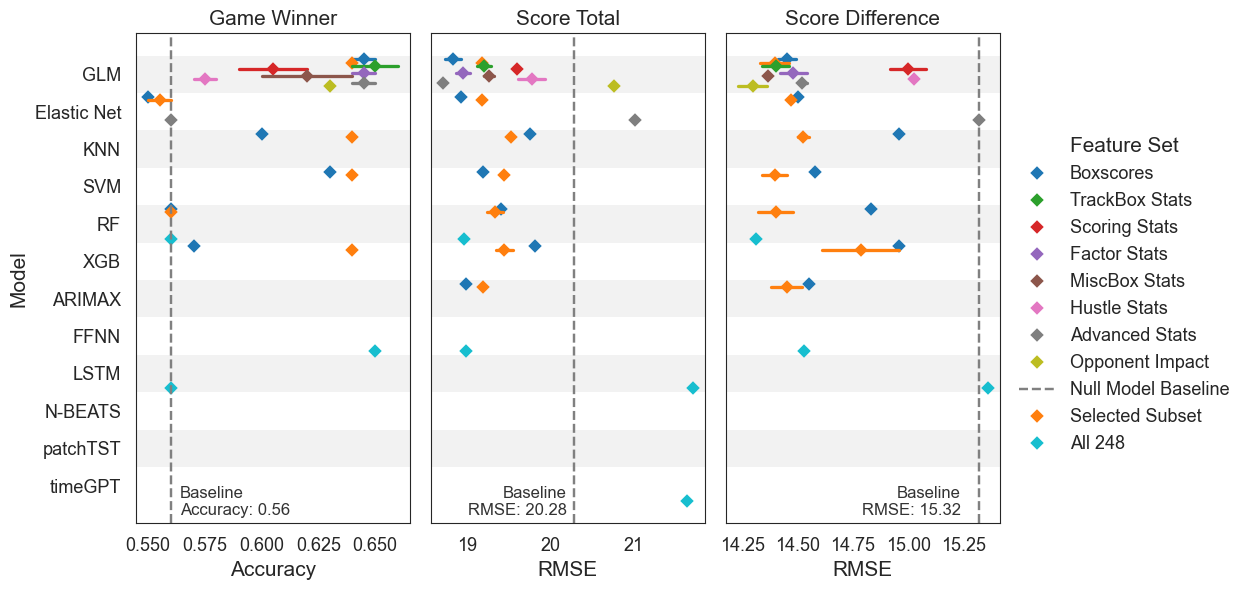

In [10]:
# Adjust font sizes using rcParams
outcomes = ['Game Winner', 'Score Total', 'Score Difference']  # Replace with your actual outcomes
plot_combined_outcome_deviation(df_models, null_model, outcomes)

<a name="1.2.-Separate"></a>
## 1.2. Separate

[Return to top](#models)

In [276]:
def plot_outcome_deviation(df, null_data, outcome, offset=0.004, dodge=5):
    
    # Set the figure size
    plt.figure(figsize=(8, 5))

    # Baseline value from the 'NULL' model
    baseline = null_data[outcome].values[0]
    
    # Mark GLM models differently to adjust dodging
    df['Model Type'] = df['Model'].apply(lambda x: 'GLM' if 'GLM' in x else 'Other')

    # Define your custom order for the models here
    custom_model_order = ['GLM', 'Elastic Net', 'KNN', 'SVM', 'RF', 'XGB', 
                          'ARIMAX', 'FFNN', 'LSTM', 'N-BEATS', 'patchTST', 'timeGPT']  

    # Ensure the DataFrame is sorted by this custom order
    model_order_categorical = pd.Categorical(df['Model'], categories=custom_model_order, ordered=True)
    df['Model'] = model_order_categorical
    sorted_df = df.sort_values(by='Model')
    
    # Create the combined deviation plot
    ax = sns.pointplot(data=sorted_df, x=outcome, y='Model', hue='Feature Set', order=custom_model_order,
                       join=False, palette='tab10', dodge=dodge,  
                       markers='D', scale=0.8, orient="h")

    # Add a vertical line for the 'NULL' model baseline
    plt.axvline(x=baseline, color='gray', linestyle='--', label='Null Model Baseline')

    # Place the text just below the last model, adjusting the position as needed
    # Conditional x-axis label text based on the outcome value
    if outcome == "Game Winner":
        baseline_text = 'Baseline Accuracy'
        text_x_position = baseline + offset  
        horizontal_alignment = 'left'
    else:
        baseline_text = 'Baseline RMSE'
        text_x_position = baseline - offset 
        horizontal_alignment = 'right'
        
    num_models = len(custom_model_order)
    plt.text(text_x_position, num_models - 2, f'{baseline_text}: {baseline:.2f}', 
         color='#333333', fontsize=10, verticalalignment='top', horizontalalignment=horizontal_alignment)

    # Adding alternating grey and white stripes in the background
    for i in range(len(custom_model_order)):
        if i % 2 == 0:
            plt.axhspan(i-0.5, i+0.5, color='grey', alpha=0.1, lw=0)

    # Configure plot aesthetics
    ax.set_title(f'Performance of {outcome} Compared to Null Model Baseline')
    ax.set_ylabel('Model')

    # Conditional x-axis label text based on the outcome value
    if outcome == "Game Winner":
        xlabel = f'{outcome} Accuracy'
    else:
        xlabel = f'{outcome} RMSE'

    # Set the modified x-axis label
    ax.set_xlabel(xlabel)

    # Extract handles and labels from the existing plot
    handles, labels = ax.get_legend_handles_labels()

    # Identify the indexes of the items you want to move to the bottom
    selected_subset_index = labels.index('Selected Subset')
    all_248_index = labels.index('All 248')

    # Move 'Selected Subset' and 'All 248' to the end of the lists
    selected_handles = [handles[selected_subset_index], handles[all_248_index]]
    selected_labels = [labels[selected_subset_index], labels[all_248_index]]

    # Remove 'Selected Subset' and 'All 248' from their original positions
    for index in sorted([selected_subset_index, all_248_index], reverse=True):
        del handles[index]
        del labels[index]

    # Append them back to the end
    handles += selected_handles
    labels += selected_labels

    # Create a new legend with the adjusted order
    ax.legend(handles, labels, title='Feature Set', loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    
    plt.tight_layout()
    plt.show()

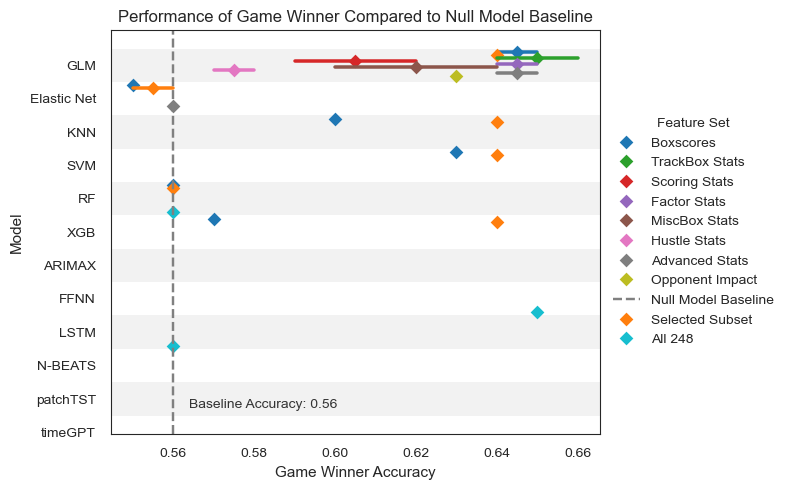

In [278]:
plot_outcome_deviation(df_models, null_model, 'Game Winner', dodge=0.8)

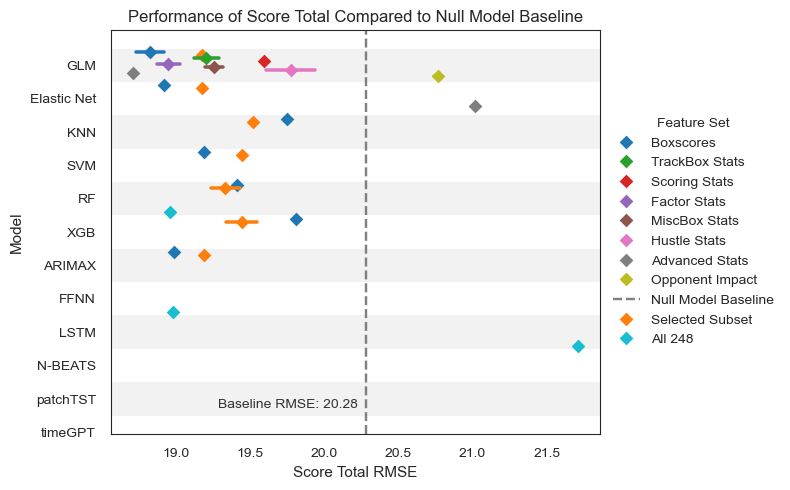

In [279]:
plot_outcome_deviation(df_models, null_model, 'Score Total', dodge=0.8, offset=0.05)

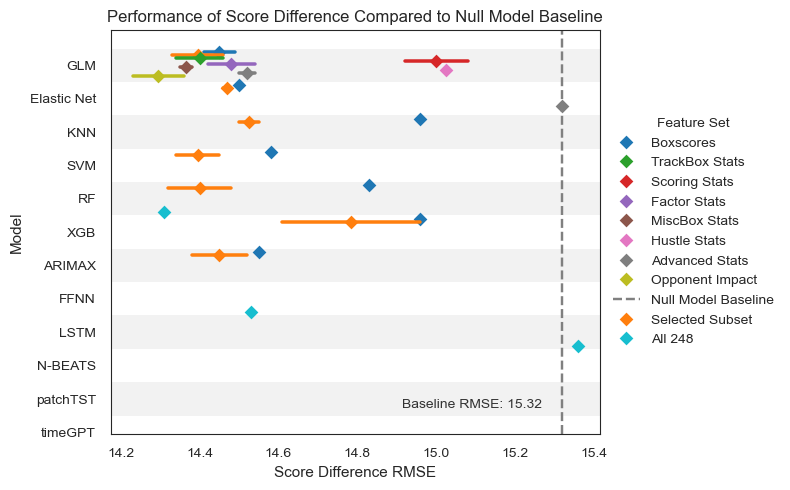

In [280]:
plot_outcome_deviation(df_models, null_model, 'Score Difference', dodge=0.8, offset=0.05)